## Checkout.com - Payment Success Exploratory Data Analysis

This notebook will cover the following:
* 5 insights related to payment performance
* Insight visualisations
* Actionable recommendations on any identified issues from analysis (such as an A/B test to improve performance)

### 1. Data preparation

In [20]:
# import required libraries
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # view all columns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import squarify

In [21]:
# identify path to source data file
dataset_path = os.path.join(os.getcwd(), 'src', 'Interview_test_data - Transactions.xlsx')

# load each excel sheet into a pandas dataframe
payments_df = pd.read_excel(dataset_path, sheet_name='transactions')
card_data_df = pd.read_excel(dataset_path, sheet_name='card_data')
dictionary_df = pd.read_excel(dataset_path, sheet_name='dictionary') # not required, but useful for referencing

In [22]:
# check and verify suitable data types
# payments_df.dtypes
payments_df['TRANSACTION_DATE'] = pd.to_datetime(payments_df['TRANSACTION_DATE'])
# card_data_df.dtypes # all OK

# view high-level dataframe information
# payments_df.info()
# card_data_df.info()

In [23]:
# replace any empty values with NaN
payments_df.replace('', np.nan, inplace=True)
card_data_df.replace('', np.nan, inplace=True)

In [24]:
# merge payments & card dataframe: total rows unchanged, so no duplications
total_df = payments_df.merge(card_data_df, left_on='CARD_FINGERPRINT', right_on='card_fingerprint')

### 2. Data exploration

The key subset of data to understand is within *IS_AUTHORISED*.

Text(0.5, 1.0, 'Unauthorised txn count and percentage')

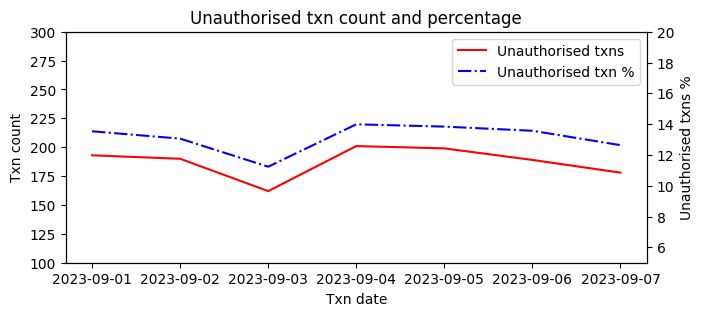

In [25]:
# count number of unauthorised transactions
auth_date_df = total_df[['IS_AUTHORISED', 'TRANSACTION_DATE']].value_counts().reset_index(name='counts').sort_values(by=['IS_AUTHORISED', 'TRANSACTION_DATE']).reset_index(drop=True)
auth_date_pivot = auth_date_df.pivot_table(index='TRANSACTION_DATE', columns='IS_AUTHORISED', values='counts', aggfunc='sum', fill_value=0)
# running percentage of unauthorised transactions to total transaction count
auth_date_pivot['percentage_unauth'] = (auth_date_pivot[0] / (auth_date_pivot[0] + auth_date_pivot[1])*100)

# plot unauthorised transactions
fig, ax1 = plt.subplots(figsize=(7.5, 3))
# ax1.plot(auth_date_pivot.index, auth_date_pivot[1], color='green', label='Authorised txns')
ax1.plot(auth_date_pivot.index, auth_date_pivot[0], color='red', label='Unauthorised txns')
ax1.set_xlabel('Txn date')
ax1.set_ylabel('Txn count')
ax1.set_ylim(100,300)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# plot running percentage of unauthorised transactions to total transaction count
ax2 = ax1.twinx()
ax2.plot(auth_date_pivot.index, auth_date_pivot['percentage_unauth'], color='blue', linestyle='dashdot', label='Unauthorised txn %')
ax2.set_ylabel('Unauthorised txns %')
ax2.set_ylim(5,20)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
plt.title('Unauthorised txn count and percentage')

The plot above shows that the percentage of unauthorised transactions as compared to the total number of transactions follows trend with the variation of unauthorised transaction counts i.e., when unauthorised transaction counts drop, so does the relative volume - no unusual spikes or deviations.

In [26]:
# create separate dataframes for authorised vs unauthorised transactions
unauth_txns = total_df[total_df['IS_AUTHORISED'] == 0]
auth_txns = total_df[total_df['IS_AUTHORISED'] == 1]

Text(0.5, 1.0, 'Mean authorised versus unauthorised txn value EUR')

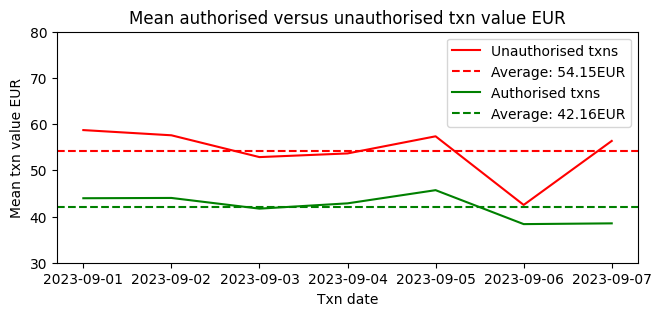

In [27]:
# identify average value of unauthorised and authorised transactions
auth_value_df = total_df[['IS_AUTHORISED', 'TRANSACTION_DATE', 'TRANSACTION_AMOUNT_EUR']].groupby(['IS_AUTHORISED', 'TRANSACTION_DATE']).mean()
auth_value_pivot = auth_value_df.pivot_table(index='TRANSACTION_DATE', columns='IS_AUTHORISED', values='TRANSACTION_AMOUNT_EUR', aggfunc='sum', fill_value=0)
auth_value_pivot['unauth_avg_value'] = auth_value_pivot[0].mean()
auth_value_pivot['auth_avg_value'] = auth_value_pivot[1].mean()
avg_value_unath = auth_value_pivot['unauth_avg_value'][0]
avg_value_auth = auth_value_pivot['auth_avg_value'][0]

# plot transactions
fig, ax1 = plt.subplots(figsize=(7.5, 3))
ax1.plot(auth_value_pivot.index, auth_value_pivot[0], color='red', label='Unauthorised txns')
ax1.axhline(y=avg_value_unath, color='red', linestyle='dashed', label=f'Average: {avg_value_unath:.2f}EUR')
ax1.plot(auth_value_pivot.index, auth_value_pivot[1], color='green', label='Authorised txns')
ax1.axhline(y=avg_value_auth, color='green', linestyle='dashed', label=f'Average: {avg_value_auth:.2f}EUR')
ax1.set_xlabel('Txn date')
ax1.set_ylabel('Mean txn value EUR')
ax1.set_ylim(30.00,80.00)
ax1.legend(loc='upper right')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title('Mean authorised versus unauthorised txn value EUR')

The plot shows the mean value of authorised versus unauthorised transactions across the period, as well as the average of these lines - unauthorised transactions tend to be higher value.

Several features seem likely to be impacting transaction success (i.e. *IS_AUTHORISED*), let's now compare the total values in each column for both datasets.

In [28]:
# subset of columns to identify difference in authorised versus unauthorised transactions
col_count_df = total_df[[
    'IS_AUTHORISED',
    'IS_CARD_VERIFICATION',
    'IS_NETWORK_TOKEN_USED',
    'AVS_CHECK',
    'STORED_CARD',
    'CVV_PRESENT',
    'CVV_CHECK',
    'HAS_THREE_DS',
    'HAS_THREE_DS_EXEMPTION',
    'IS_THREE_DS_CHALLENGED',
    'IS_RETRIED',
    'HAS_ISO_MESSAGE',
    'CARD_SCHEME']].copy()

# parse each column from subset
for col in col_count_df.columns[1:]:
    # transform dataframe from wide format to long format so that operations can be applied whilst retaining desired structure
    melted_df = col_count_df.melt(id_vars=[col, 'IS_AUTHORISED'], var_name='Column', value_name='Column value')
    # count column values for each column and unstack to re-pivot data
    feature_count_df = melted_df.groupby(['Column', 'Column value', 'IS_AUTHORISED']).size().unstack(fill_value=0)
feature_count_df.columns.names = [None] * len(feature_count_df.columns.names)
feature_count_df.reset_index(inplace=True)
feature_count_df

,Column,Column value,0,1
0,AVS_CHECK,Address not verified,812,8667
1,AVS_CHECK,Cardholder street address and ZIP code match,0,7
2,AVS_CHECK,Postal code and address matches,0,12
3,AVS_CHECK,Street address and ZIP code do not match,0,1
4,AVS_CHECK,"Street address matches, ZIP code does not match",0,1
5,CVV_CHECK,Card verification not performed,528,3478
6,CVV_CHECK,"Card verification performed, and CVV was invalid",91,0
7,CVV_CHECK,"Card verification performed, and CVV was valid",273,5210
8,CVV_PRESENT,False,287,2324
9,CVV_PRESENT,True,605,6363


From the above table, we can see that several feature values are seen to be impacted between unauthorised and authorised transactions. 

### 3. Data insights

#### 3.1 Expired cards

In [29]:
# convert MMYYYY to date format
total_df['card_expiry_MMYYYY'] = '01-' + total_df['card_expiry_month'].astype(str) + '-' + total_df['card_expiry_year'].astype(str)
# apply day as last day of that month
total_df['card_expiry_date'] = pd.to_datetime(total_df['card_expiry_MMYYYY'], format='%d-%m-%Y') + pd.offsets.MonthEnd(0) # cards expire at the end of month
# identify authorised transactions where card expiry date is before the transaction date and the response summary isn't expired cards
expired_cards = total_df[(total_df['card_expiry_date'] < total_df['TRANSACTION_DATE']) & (total_df['GATEWAY_RESPONSE_SUMMARY'] != 'Expired Card') & (total_df['IS_AUTHORISED'] == 1)][['TRANSACTION_AMOUNT_EUR', 'TRANSACTION_DATE','card_expiry_date','STORED_CARD','GATEWAY_RESPONSE_SUMMARY', 'IS_AUTHORISED']].sort_values(by='IS_AUTHORISED').reset_index(drop=True)
expired_cards

,TRANSACTION_AMOUNT_EUR,TRANSACTION_DATE,card_expiry_date,STORED_CARD,GATEWAY_RESPONSE_SUMMARY,IS_AUTHORISED
0,33.423,2023-09-06,2023-07-31,True,Approved,1
1,18.902,2023-09-04,2023-08-31,True,Approved,1
2,54.030,2023-09-01,2023-04-30,True,Approved,1
3,36.182,2023-09-01,2023-06-30,True,Approved,1
4,120.730,2023-09-06,2023-07-31,True,Approved,1
5,123.444,2023-09-04,2023-05-31,True,Approved,1


In [30]:
# calculate percentage of false positive transaction value to total transactions value in dataset
expired_cards['TRANSACTION_AMOUNT_EUR'].sum()
(expired_cards['TRANSACTION_AMOUNT_EUR'].sum() / total_df['TRANSACTION_AMOUNT_EUR'].sum())

0.0008837790538698793

There are 6 transactions with IS_AUTHORISED=1 and GATEWAY_RESPONSE_SUMMARY='Approved' for cards past their expiration date. The total value of these transactions is 386.711 EUR, the proportion of these transactions to the provided dataset is almost 9 basis points. Using the current annual revenue of Checkout.com, this is equivalent to around 300k EUR of expired card transactions.

This is likely a result of synthetic data production for this task, however a simple recommendation (correction) would be to prevent transactions where the card expiration date has passed.

#### 3.2 Authorisation rates for various card types

In [31]:
# isolate dataframe on card type
card_df = total_df[['card_type','IS_AUTHORISED']].copy()
# count auth/unauth rates
card_auth_df = card_df[card_df['IS_AUTHORISED'] == 1].groupby('card_type').count().reset_index()
card_unauth_df = card_df[card_df['IS_AUTHORISED'] == 0].groupby('card_type').count().reset_index()

# merge dataframes
card_percentage_df = card_auth_df.merge(card_unauth_df, left_on='card_type', right_on='card_type')
# calculate percentage of unauthorised transactions by card type
card_percentage_df['unauthorised_percentage'] = (card_percentage_df['IS_AUTHORISED_y'] / card_percentage_df['IS_AUTHORISED_x']*100).round(1)
card_percentage_df = card_percentage_df.rename(columns={'IS_AUTHORISED_y': 'unauthorised_txns', 'IS_AUTHORISED_x': 'authorised_txns'})
card_percentage_df

,card_type,authorised_txns,unauthorised_txns,unauthorised_percentage
0,credit,1690,197,11.7
1,debit,5889,874,14.8
2,deferred debit,108,19,17.6
3,prepaid,1001,222,22.2


The dataframe shows that the credit cards have the lowest percentage of unauthorised transactions, whereas prepaid cards have the highest.

Recommendations:
1. A/B test: Make credit and debit payment options more prominent at checkout page to identify if reduced prepaid rates.
2. Improve prepaids cards performance - the code below identifies the number of GATEWAY_RESPONSE_SUMMARY for these unauthorised transactions. Insufficient Funds is the most frequently occuring reason for payment failures with 3DS related failures as the second and third most common.

In [32]:
# isolate unauthorised transactions from prepaid cards and count unique response summaries
prepaid_responses = total_df[(total_df['card_type'] == 'prepaid') & (total_df['IS_AUTHORISED'] == 0)]['GATEWAY_RESPONSE_SUMMARY'].value_counts().reset_index()
prepaid_responses = prepaid_responses.rename(columns={'index': 'GATEWAY_RESPONSE_SUMMARY', 'GATEWAY_RESPONSE_SUMMARY': 'GRS_count'})
# calculate percentage of response summaries against total number of responses
prepaid_responses['GRS_percentage'] = (prepaid_responses['GRS_count'] / prepaid_responses['GRS_count'].sum() *100).round(1)
prepaid_responses

,GATEWAY_RESPONSE_SUMMARY,GRS_count,GRS_percentage
0,Insufficient Funds,77,34.7
1,Cardholder failed 3D-Secure authentication,35,15.8
2,Initial 3DS transaction not completed within 1...,33,14.9
3,Security,19,8.6
4,Declined - Do Not Honour,17,7.7
5,Policy,13,5.9
6,Exceeds Withdrawal Value/Amount Limits,10,4.5
7,Risk Blocked Transaction,4,1.8
8,Transaction rejected - AMLD5,2,0.9
9,Invalid Transaction,2,0.9


#### 3.3 Authorisation rates for various banks

In [33]:
# isolate dataframe on card issuer and issuer country
bank_df = total_df[['issuer_name', 'issuer_country_name','IS_AUTHORISED']].copy()
# count the number of transactions per issuer
bank_txns_df = bank_df.groupby(['issuer_name', 'issuer_country_name']).count().reset_index()
# calculate percentage of issuer transactions to total transactions i.e. volume percentage 
bank_txns_df['txns_percentage'] = (bank_txns_df['IS_AUTHORISED'] / bank_txns_df['IS_AUTHORISED'].sum()*100)
# count auth/unauth rates
bank_auth_df = bank_df[bank_df['IS_AUTHORISED'] == 1].groupby(['issuer_name', 'issuer_country_name']).count().reset_index()
bank_unauth_df = bank_df[bank_df['IS_AUTHORISED'] == 0].groupby(['issuer_name', 'issuer_country_name']).count().reset_index()

# merge dataframes
bank_percentage_df = bank_auth_df.merge(bank_unauth_df, left_on=['issuer_name', 'issuer_country_name'], right_on=['issuer_name', 'issuer_country_name'])
bank_total_df = bank_percentage_df.merge(bank_txns_df, left_on=['issuer_name', 'issuer_country_name'], right_on=['issuer_name', 'issuer_country_name'])
# calculate percentage of unauthorised transactions by bank
bank_total_df['unauthorised_percentage'] = (bank_total_df['IS_AUTHORISED_y'] / bank_total_df['IS_AUTHORISED_x']*100)
bank_total_df = bank_total_df.rename(columns={'IS_AUTHORISED_y': 'unauthorised_txns', 'IS_AUTHORISED_x': 'authorised_txns', 'IS_AUTHORISED': 'total_txns'})
bank_total_df.sort_values(by='unauthorised_percentage')
# sort by volume percentage and then unauthorised transactions percentage
bank_plot_df = bank_total_df[['issuer_name', 'issuer_country_name', 'unauthorised_txns', 'txns_percentage', 'unauthorised_percentage']].sort_values(by=['txns_percentage', 'unauthorised_percentage'], ascending=False)
bank_plot_df.head(10)

,issuer_name,issuer_country_name,unauthorised_txns,txns_percentage,unauthorised_percentage
53,CREDIT AGRICOLE S.A.,France,143,8.52,20.169252
43,CAIXABANK S.A.,Spain,61,7.47,8.892128
33,BPCE,France,81,6.65,13.869863
98,POSTEPAY S.P.A,Italy,66,3.92,20.245399
30,BNP PARIBAS,France,46,3.61,14.603175
24,BANQUE FEDERATIVE DU CREDIT MUTUEL (BFCM),France,37,3.22,12.982456
40,CAIXA GERAL DE DEPOSITOS S.A.,Portugal,45,3.02,17.509728
8,BANCO BILBAO VIZCAYA ARGENTARIA S.A. (BBVA),Spain,24,3.00,8.695652
76,LA BANQUE POSTALE,France,89,2.90,44.278607
17,BANCO SANTANDER S.A.,Spain,21,2.80,8.108108


Three different ways to visualise this data.

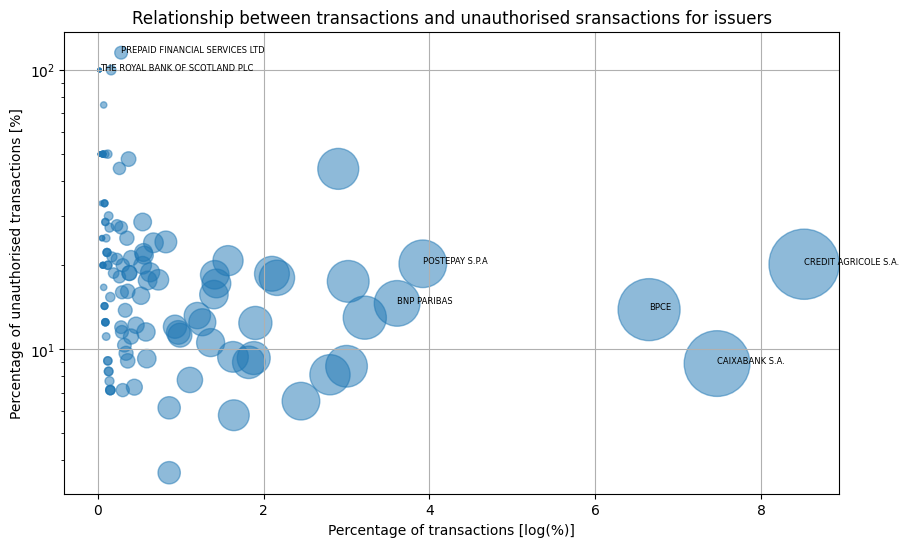

In [34]:
# identify top banks by relative volume and unauthorised transaction percentage
df_sorted_txns = bank_plot_df.sort_values(by='txns_percentage', ascending=False).head(5)
df_sorted_unauth = bank_plot_df.sort_values(by='unauthorised_percentage', ascending=False).head(2)
top_banks = pd.concat([df_sorted_txns, df_sorted_unauth]).drop_duplicates()

# scatter plot with relative volume as marker size
plt.figure(figsize=(10, 6))
plt.scatter(bank_plot_df['txns_percentage'], bank_plot_df['unauthorised_percentage'], s=bank_plot_df['txns_percentage']*300, alpha=0.5)

# text labels for top issuers
for i, row in top_banks.iterrows():
    plt.text(row['txns_percentage'], row['unauthorised_percentage'], row['issuer_name'], fontsize=6)

# plot data
plt.xlabel('Percentage of transactions [log(%)]')
plt.ylabel('Percentage of unauthorised transactions [%]')
plt.title('Relationship between transactions and unauthorised sransactions for issuers')
# log y scale for easier viewing
plt.yscale('log')
plt.grid(True)
plt.show()

This view shows a scatter plot with the size of the markers equivalent to the relative volume and the percentage of unauthorised transactions on the y-axis. Here, CREDIT AGRICOLE S.A., CAIXABANK S.A., and BPCE are prominent due to their relative volume, though their unauthorised percentage is within the majority. PREPAID FINANCIAL SERVICES PLS and THE ROYAL BANK OF SCOTLAND PLC have the highest unauthorised percentage, though their relative volume is small.

/var/folders/rw/57lr6wsn1xg3nr3drbny9mhr0000gn/T/ipykernel_1107/985257612.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical')


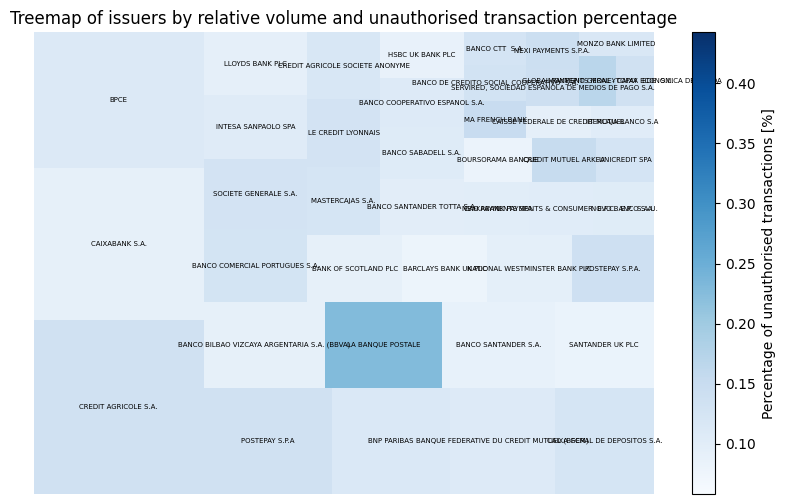

In [35]:
# subset of desired plot data i.e., at least 0.5% relative volume and at least 5% unauthorised transaction percentage
treemap_df = bank_plot_df.copy()
treemap_df = treemap_df[(treemap_df['txns_percentage'] >= 0.5) & (treemap_df['unauthorised_percentage'] >= 5)]
treemap_df['txns_percentage'] = treemap_df['txns_percentage']/100
treemap_df['unauthorised_percentage'] = treemap_df['unauthorised_percentage']/100

# provide sizes and colour map
sizes = treemap_df['txns_percentage']
colour_map = plt.cm.Blues

# plot treemap using squarify
plt.figure(figsize=(10, 6))
squarify.plot(sizes=sizes, label=treemap_df['issuer_name'], color=colour_map(treemap_df['unauthorised_percentage']), alpha=1, text_kwargs={'fontsize': 5})
norm = plt.Normalize(treemap_df['unauthorised_percentage'].min(), treemap_df['unauthorised_percentage'].max())
sm = plt.cm.ScalarMappable(cmap=colour_map, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical')
cbar.set_label('Percentage of unauthorised transactions [%]')
plt.title('Treemap of issuers by relative volume and unauthorised transaction percentage')
plt.axis('off')
plt.show()

This treemap displays the issuers that have at least 0.5% relative volume and at least 5% unauthorised transaction percentage. In this view, LA BANQUE POSTALE is the most prominent as it has the highest percentage of unauthorised transactions and is large in volume relative to the dataset. The volumes of CREDIT AGRICOLE S.A. and CAIXABANK S.A. are large, though their percentage of unauthorised transactions is not as prominent. Similarly, the highest percentage of unauthorised transactions issuers are not displayed due to their relative volume.

/var/folders/rw/57lr6wsn1xg3nr3drbny9mhr0000gn/T/ipykernel_1107/1659856378.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colours = cm.get_cmap('Paired', len(unique_countries))


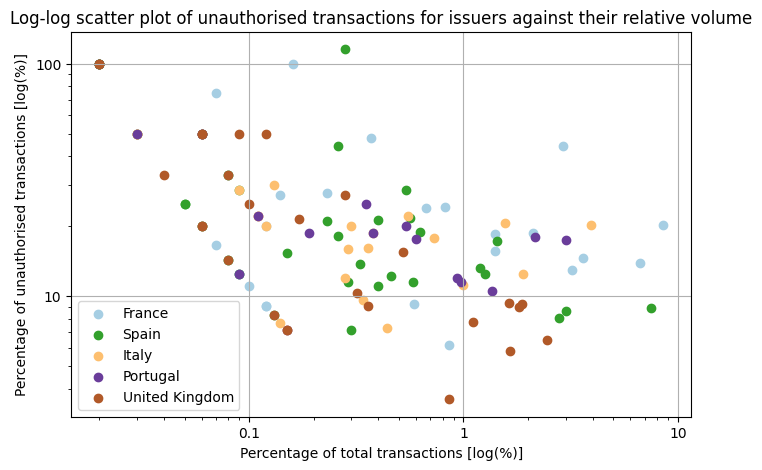

In [36]:
# identify unqiue countries
unique_countries = bank_plot_df['issuer_country_name'].unique()
# create colour map for each country
colours = cm.get_cmap('Paired', len(unique_countries))

plt.figure(figsize=(8, 5))
for i, country in enumerate(unique_countries):
    country_df = bank_plot_df[bank_plot_df['issuer_country_name'] == country]
    # scatter plot of unauthorised transaction percentage against relative volume
    plt.scatter(country_df['txns_percentage'], country_df['unauthorised_percentage'], color=colours(i), label=country)

# log-log scale for easier viewing
plt.title('Log-log scatter plot of unauthorised transactions for issuers against their relative volume')
plt.xlabel('Percentage of total transactions [log(%)]')
plt.ylabel('Percentage of unauthorised transactions [log(%)]')
plt.xscale('log')
plt.yscale('log')
plt.xticks(ticks=[0.1, 1, 10], labels=['0.1', '1', '10'])
plt.yticks(ticks=[10, 100], labels=['10', '100'])
plt.grid(True)
plt.legend()
plt.show()

This last plot shows that there isn't a significant grouping of unauthorised transactions for certain issuer countries. A KNN algorithm could define the relationship between these groups better than the initial visual inspection.

Observations:
1. PREPAID FINANCIAL SERVICES PLS has the greatest unauthorised percentage, though smaller in relative volume.
2. LA BANQUE POSTALE is the highest unauthorised percentage of the large relative volume issuers.

Recommendation:
1. Optimising payments with LA BANQUE POSTALE will provide the greatest improvement in payment performance as they hold substantial relative volume, contributing to a large number of unauthorised transactions.
2. Perform KNN to identify regional differences.

In [41]:
LBP_df = total_df[total_df['issuer_name'] == 'LA BANQUE POSTALE']['GATEWAY_RESPONSE_SUMMARY'].value_counts()
LBP_df

Approved                                                                                 201
Initial 3DS transaction not completed within 15 minutes                                   31
Insufficient Funds                                                                        30
Cardholder failed 3D-Secure authentication                                                15
Invalid Card Number                                                                        9
Blocked, first use - transaction from new cardholder, and card not properly unblocked      2
Suspected Fraud                                                                            1
Decline for CVV2 Failure                                                                   1
Name: GATEWAY_RESPONSE_SUMMARY, dtype: int64

#### 3.4 Authorisation rates for various schemes

In [37]:
# isolate dataframe on card scheme
scheme_df = total_df[['CARD_SCHEME','IS_AUTHORISED']].copy()
# count auth/unauth rates
scheme_auth_df = scheme_df[scheme_df['IS_AUTHORISED'] == 1].groupby('CARD_SCHEME').count().reset_index()
scheme_unauth_df = scheme_df[scheme_df['IS_AUTHORISED'] == 0].groupby('CARD_SCHEME').count().reset_index()

# merge dataframes and identify percentage of unauthorised transactions
scheme_percentage_df = scheme_auth_df.merge(scheme_unauth_df, left_on='CARD_SCHEME', right_on='CARD_SCHEME')
scheme_percentage_df['unauthorised_percentage'] = (scheme_percentage_df['IS_AUTHORISED_y'] / scheme_percentage_df['IS_AUTHORISED_x']*100).round(1)
scheme_percentage_df = scheme_percentage_df.rename(columns={'IS_AUTHORISED_y': 'unauthorised_txns', 'IS_AUTHORISED_x': 'authorised_txns'})
scheme_percentage_df

,CARD_SCHEME,authorised_txns,unauthorised_txns,unauthorised_percentage
0,mastercard,3907,607,15.5
1,visa,4781,705,14.7


Both Mastercard and Visa have around 15% unauthorised transactions - recommend working with the schemes to reduce this number. Let's investigate the scheme components further, the presence of the ISO message should be a good indicator.

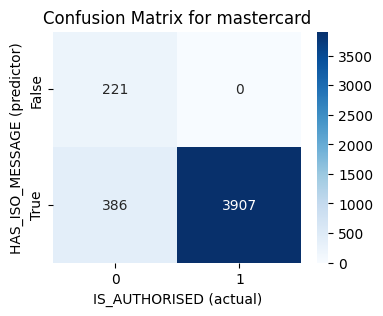

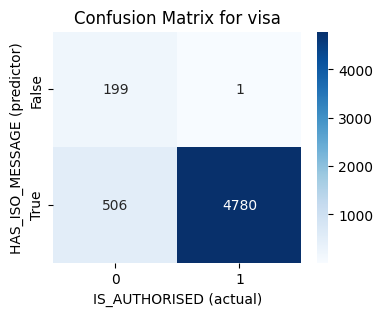

In [42]:
# isolate dataframe on card scheme and iso message
scheme_iso_df = total_df[['CARD_SCHEME', 'HAS_ISO_MESSAGE', 'IS_AUTHORISED']].copy()

# identify unique schemes
unique_schemes = scheme_iso_df['CARD_SCHEME'].unique()

# plot confusion matrix for each scheme
for scheme in unique_schemes:
    subset = scheme_iso_df[scheme_iso_df['CARD_SCHEME'] == scheme]
    conf_matrix = pd.crosstab(subset['HAS_ISO_MESSAGE'], subset['IS_AUTHORISED'])

    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
    
    plt.xlabel('IS_AUTHORISED (actual)')
    plt.ylabel('HAS_ISO_MESSAGE (predictor)')
    plt.title(f'Confusion Matrix for {scheme}')
    plt.show()

If we consider HAS_ISO_MESSAGE as the predictor value for a scheme authorising a transaction, we see that the bottom right cell is the true positives i.e., ISO message was present and payment authorised. The top left cell is the true negatives i.e., no ISO message present and payment unauthorised. 

Observations:
1. We see that no transactions are authorised where no ISO message was present for Mastercard, whereas 1 was processed for Visa.
2. We see that there are a large number of unauthorised payments where no ISO message was present for both Mastercard and Visa.

Recommendations:
1. Optimise the largest number of transactions in the leading diagonal i.e. true positives and true negatives.
2. Optimise the largest number of transactions in the bottom right cell i.e. increasing true positives and the success of payments in regards to scheme.